***
###### Setup

Start off by importing the necessary libraries and tools.

In [262]:
import pandas # reading/maniuplating CSV files
import nltk # preprocessing
import spacy # preprocessing
import en_core_web_sm
import gensim # Latent Dirichlet Allocation
from pprint import pprint # pretty print

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

# analysis tools
import collections
import numpy as np

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Define constants.

In [263]:
NUM_TOPICS = 3
ALPHA = 0.05
BETA = 0.05

Initialize spacy 'en' model.

In [264]:
nlp = en_core_web_sm.load(disable=['parser', 'ner']) # keeping only tagger component for efficiency

***
###### Data Compilation

Load the relevant meta and text data of the active grants, while extracting the relevant data rows.

In [265]:
awardedNINR19 = pandas.read_excel(r"./../data/awarded-grants-NINR-2019.xlsx")
print(awardedNINR19.head)

<bound method NDFrame.head of      Type Actv        Project                         PI Name %tile Score  \
0       1  F31  NR018362-01A1             PIASECKI, REBECCA J     -    18   
1       1  F31  NR018363-01A1               NOWAK, ALEXANDRA      -    22   
2       1  F31  NR018369-01A1                THUL, TAYLOR ANN     -    23   
3       1  F31  NR018373-01A1  MENDEZ, KYRA JENNIFER WALIGORA     -    20   
4       1  F31  NR018574-01A1                VARTY, MAUREEN M     -    25   
..    ...  ...            ...                             ...   ...   ...   
366     5  T32    NR016914-03                TITLER, MARITA G     -    20   
367     5  T32    NR016920-03         MIASKOWSKI, CHRISTINE A     -    20   
368     5  U2C    NR014637-07                  KUTNER, JEAN S     -    30   
369     7  R01    NR014846-04                    DONG, XINQI     12    23   
370     7  R01    NR016957-02                DOWNS, CHARLES A    19    29   

                                             

Remove empty texts.

In [266]:
#awardedNINR19 = awardedNINR19[pandas.notna(awardedNINR19['Abstract Text (only)'])] # remove if abstract is empty
awardedNINR19 = awardedNINR19[awardedNINR19['Abstract Text (only)'] != "-"] # remove rows with abstracts that have dashes
print(awardedNINR19['Abstract Text (only)'][0:5])

0    PROPOSAL SUMMARY Over 200,000 patients experie...
1    Project Summary/Abstract African American wome...
2    PROJECT SUMMARY Background: Synthetic oxytocin...
3    Project Summary An estimated 80% of the 5.4 to...
4    Project Summary / Abstract Transition from ped...
Name: Abstract Text (only), dtype: object


Concatenate columns 'T', 'A', 'N', and 'S' to form long strings for each application, representing the document.

In [267]:
awardedNINR19['text'] = awardedNINR19['Title'].map(str) + " " + awardedNINR19['Abstract Text (only)'].map(str) + " " + awardedNINR19['SA Text'].map(str)
awardedNINR19 = awardedNINR19[pandas.notna(awardedNINR19['text'])]

Remove unnecessary columns.

In [268]:
awardedNINR19 = awardedNINR19.drop(columns = ['Title', 'Abstract Text (only)', 'SA Text']) 

In [269]:
awardedNINR19.head()

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,Medical emergency team trigger clusters: Descr...
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,Neighborhood Disorder and Epigenetic Regulatio...
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,Evaluating the Contribution of Synthetic Oxyto...
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,Dementia informal caregivers mobile app use an...
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,Factors Predicting Transition Readiness in You...


***
###### Text Preprocessing

Clean up the text by stripping whitespace and keeping only letters.

In [270]:
awardedNINR19['text'] = awardedNINR19['text'].str.replace("\n", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("\r", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("-", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("'", "")

awardedNINR19['text'] = awardedNINR19['text'].str.replace("[^abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ]+", " ") 

awardedNINR19['text'] = awardedNINR19['text'].str.lower() 

awardedNINR19['text'] = awardedNINR19['text'].str.replace("abstract", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("project", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("proposal", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("summary", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("narrative", " ") 
awardedNINR19['text'] = awardedNINR19['text'].str.replace("background", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("supplement", " ") 
awardedNINR19['text'] = awardedNINR19['text'].str.replace("significance", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("overall", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("title", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("specific aims", " ") 
awardedNINR19['text'] = awardedNINR19['text'].str.replace("goal", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("research plan", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("overview", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("\\s+", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("description provided by applicant", " ") 

awardedNINR19['text'] = awardedNINR19['text'].str.strip()

Only keep documents with unique text.

In [271]:
print(len(awardedNINR19.index))
awardedNINR_new = awardedNINR19.drop_duplicates(subset=['text'])
print(len(awardedNINR_new.index))

369
362


Load stopwords (http://www.ai.mit.edu/projects/jmlr/papers/volume5/lewis04a/a11-smart-stop-list/english.stop) and our own collection of words to remove.

In [272]:
with open("stopwords.txt") as f: # words loaded from local .txt file
    remove_words_stop = [line.strip() for line in f if line.strip()]
    
with open("lemma_stopwords.txt") as f:
    remove_words_lemma = [line.strip() for line in f if line.strip()]
    
remove_words = remove_words_stop + remove_words_lemma
remove_words = [t.replace("'", "") for t in remove_words]
print(remove_words)

['PAULWORDS', 'read', 'paramet', 'devic', 'detail', 'mab', 'calcul', 'research', 'user', 'communiti', 'support', 'dissemin', 'estim', 'method', 'ALAZWORDS', 'develop', 'aim', 'model', 'STOPWORDS', 'a', 'as', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'aint', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', 'arent', 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', 'cmon', 'cs', 'came', 'can', 'cant', 'cannot', '

Split the texts into lists of words. Also check against stopwords of the word's stem and remove. Here we apply Snowball Stemming (http://snowball.tartarus.org/texts/introduction.html).

In [273]:
sno = nltk.stem.SnowballStemmer('english') # import from nltk library

In [274]:
def stem_sentences(text): # helper function
    tokens = text.split()
    split_text = [t for t in tokens if sno.stem(t) not in remove_words]
    return(split_text)

In [275]:
awardedNINR19['text'] = awardedNINR19['text'].apply(stem_sentences) # apply function for each document

In [276]:
awardedNINR19.head(20)

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,"[medical, emergency, team, trigger, clusters, ..."
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,"[neighborhood, disorder, epigenetic, regulatio..."
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,"[evaluating, contribution, synthetic, oxytocin..."
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,"[dementia, informal, caregivers, mobile, app, ..."
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,"[factors, predicting, transition, readiness, y..."
5,1,F31,NR018576-01A1,"LEBLANC, MATTHEW ROGER",-,14,201905,"BANKS, DAVID",DTRPC,PA18-671,Awarded. Fellowships only,2019,"[advanced, symptom, burden, quality, life, mul..."
6,1,F31,NR018580-01A1,"SHAW, CLARISSA ANNE",-,20,201905,"BANKS, DAVID",DTRRC,PA18-671,Awarded. Fellowships only,2019,"[resistiveness, dementia, nurse, communication..."
7,1,F31,NR018582-01,"KISSLER, KATHERINE",-,23,201901,"BANKS, DAVID",DTRWH,PA18-671,Awarded. Fellowships only,2019,"[classification, labor, dystocia, physiologic,..."
8,1,F31,NR018586-01,"KALVAS, LAURA BETH ANN",-,23,201901,"BANKS, DAVID",DTRDP,PA18-671,Awarded. Fellowships only,2019,"[sleep, disruption, delirium, critically, chil..."
9,1,F31,NR018588-01,"VASBINDER, ALEXI L",-,19,201901,"BANKS, DAVID",DTRWH,PA18-671,Awarded. Fellowships only,2019,"[biomarkers, long, term, fatigue, breast, canc..."


***
Build a bigram model of the texts.

In [277]:
texts = awardedNINR19.text.values.tolist() # creates text_values variable

In [278]:
bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)

In [279]:
bigrams = [bigram_phraser[doc] for doc in texts] # form bigrams

Lemmatize the words of the text, while only including nouns and verbs.

In [280]:
def lemmatization(texts, allowed_postags=['NOUN', 'VERB']): # helper fuction
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) # spacy function
        texts_out.append([token.lemma_ for token in doc]) #if token.pos_ in allowed_postags]) # This gets rid of many things
    return(texts_out)

In [281]:
#texts = lemmatization(bigrams)
texts = bigrams

In [282]:
#remove_words = []
#with open("lemma_stopwords.txt") as f: # words loaded from local .txt file
#    remove_words = [line.strip() for line in f if line.strip()]

#for i in range(len(texts)):
#    for remove_word in remove_words:
#        if remove_word in texts[i]:
#            texts[i] = list(filter(lambda a: a != remove_word, texts[i]))
    
#texts[1][0:5]

***
###### Latent Dirichlet Allocation

Build a dictionary and corpus for use with LDA.

In [283]:
dictionary = gensim.corpora.Dictionary(texts)
print(dictionary)

Dictionary(13222 unique tokens: ['000', '075', '1', '11', '12']...)


In [284]:
corpus = [dictionary.doc2bow(text) for text in texts] # text is list of bigrams
print(len(corpus[5]))

#new_corpus = []
#for text in corpus:
#    doc_words = []
#    for tuple in text:
#        if (tuple[1] >= 10):
#            doc_words.append(tuple)
#    new_corpus.append(doc_words)

#corpus = new_corpus
#print(len(corpus[5]))
#print(corpus)
            

369


Convert the next cell to code to run the optimization algorithm. This may take hours, depending on your machine.

In [247]:
lst = []
for t in [3, 4, 5, 6, 7, 8]: 
    for i in [0.05, 0.1, 0.5, 1, 5]: 
        for j in [0.05, 0.1, 0.5, 1, 5]: 
            param_list = []
            lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=t, id2word=dictionary, random_state=100, update_every=1, 
                                               chunksize=20, passes=10, alpha=i, eta=j, iterations=1000, per_word_topics=True) 
            print("N: " + str(t) + " ... Alpha: " + str(i) + " ... Beta: " + str(j)) 
            print(" -> Perplexity = ", lda_model.log_perplexity(corpus)) 
            coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v') 
            coherence_lda = coherence_model_lda.get_coherence() 
            print(" -> Coherence Score = ", coherence_lda) 
            
            param_list.append(t)
            param_list.append(i)
            param_list.append(j)
            param_list.append(coherence_lda)
            param_list.append(lda_model.log_perplexity(corpus))
            lst.append(param_list)
                                  
lda_param = pandas.DataFrame(lst, columns = ['Topic', 'Alpha', 'Beta', 'Coherence', 'Perplexity'])       
lda_param.to_csv('LDA_Param.csv')

N: 3 ... Alpha: 0.05 ... Beta: 0.05
 -> Perplexity =  -13.75178980456632
 -> Coherence Score =  0.3835647453881678
N: 3 ... Alpha: 0.05 ... Beta: 0.1
 -> Perplexity =  -8.696514750340786
 -> Coherence Score =  0.3571100092627886
N: 3 ... Alpha: 0.05 ... Beta: 0.5
 -> Perplexity =  -7.934011342804959
 -> Coherence Score =  0.3346328335771562
N: 3 ... Alpha: 0.05 ... Beta: 1
 -> Perplexity =  -7.9787388845844145
 -> Coherence Score =  0.40609912278879623
N: 3 ... Alpha: 0.05 ... Beta: 5
 -> Perplexity =  -8.168627598928682
 -> Coherence Score =  0.3346469451196465
N: 3 ... Alpha: 0.1 ... Beta: 0.05
 -> Perplexity =  -13.750042687464227
 -> Coherence Score =  0.3835647453881678
N: 3 ... Alpha: 0.1 ... Beta: 0.1
 -> Perplexity =  -8.694885849326372
 -> Coherence Score =  0.3614652116608655
N: 3 ... Alpha: 0.1 ... Beta: 0.5
 -> Perplexity =  -7.9350781024823736
 -> Coherence Score =  0.33434092969511253
N: 3 ... Alpha: 0.1 ... Beta: 1
 -> Perplexity =  -7.978686480741459
 -> Coherence Score

N: 5 ... Alpha: 5 ... Beta: 1
 -> Perplexity =  -8.03620734581121
 -> Coherence Score =  0.3437278449481112
N: 5 ... Alpha: 5 ... Beta: 5
 -> Perplexity =  -8.251595145894017
 -> Coherence Score =  0.4318993124111608
N: 6 ... Alpha: 0.05 ... Beta: 0.05
 -> Perplexity =  -13.597869750037205
 -> Coherence Score =  0.3611829110342748
N: 6 ... Alpha: 0.05 ... Beta: 0.1
 -> Perplexity =  -8.545056869128741
 -> Coherence Score =  0.3507915082902344
N: 6 ... Alpha: 0.05 ... Beta: 0.5
 -> Perplexity =  -7.921885523760232
 -> Coherence Score =  0.35063405194185887
N: 6 ... Alpha: 0.05 ... Beta: 1
 -> Perplexity =  -7.979785880178068
 -> Coherence Score =  0.4064682819754104
N: 6 ... Alpha: 0.05 ... Beta: 5
 -> Perplexity =  -8.171211162791455
 -> Coherence Score =  0.41385953392773267
N: 6 ... Alpha: 0.1 ... Beta: 0.05
 -> Perplexity =  -13.566061508527794
 -> Coherence Score =  0.39229566268533184
N: 6 ... Alpha: 0.1 ... Beta: 0.1
 -> Perplexity =  -8.538455372975424
 -> Coherence Score =  0.3

N: 8 ... Alpha: 5 ... Beta: 0.1
 -> Perplexity =  -8.447237197141403
 -> Coherence Score =  0.3699167121406184
N: 8 ... Alpha: 5 ... Beta: 0.5
 -> Perplexity =  -8.005630547715674
 -> Coherence Score =  0.403361238712026
N: 8 ... Alpha: 5 ... Beta: 1
 -> Perplexity =  -8.094943258677269
 -> Coherence Score =  0.4459143392736782
N: 8 ... Alpha: 5 ... Beta: 5
 -> Perplexity =  -8.300876909876594
 -> Coherence Score =  0.434985699864075


We see that the "best" model according to the highest coherence and lowest perplexity scores is a model with parameters N = 3, Alpha = 0.05, and Beta = 0.05.

Build the LDA model.

In [285]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                    num_topics=3,
                                    id2word=dictionary,
                                    random_state=100,
                                    update_every=1,
                                    chunksize=20,
                                    passes=10,
                                    alpha=0.05,
                                    eta=0.05,
                                    iterations=1000,
                                    per_word_topics=True)


Print perplexity and coherence score.

In [286]:
print("Perplexity =", lda_model.log_perplexity(corpus))
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score =", coherence_lda)

Perplexity = -13.75178980456632
Coherence Score = 0.3835647453881678


Print top 10 words for each topic.

In [287]:
p_models = lda_model.show_topics(num_words=10, formatted=False)

In [288]:
pprint(p_models)

[(0,
  [('care', 0.12536138),
   ('patients', 0.07158727),
   ('patient', 0.047396142),
   ('caregivers', 0.032370735),
   ('palliative', 0.025577871),
   ('life', 0.024024023),
   ('hf', 0.018800247),
   ('quality', 0.018011596),
   ('prep', 0.016932305),
   ('clinical', 0.016101966)]),
 (1,
  [('health', 0.01872895),
   ('intervention', 0.012456195),
   ('2', 0.011774005),
   ('1', 0.011030135),
   ('management', 0.00959982),
   ('3', 0.009405959),
   ('outcomes', 0.00854519),
   ('study', 0.008413092),
   ('chronic', 0.007875532),
   ('risk', 0.007174275)]),
 (2,
  [('pain', 0.06593698),
   ('symptoms', 0.0397749),
   ('symptom', 0.031000543),
   ('patients', 0.024644805),
   ('sleep', 0.023351464),
   ('cancer', 0.016018225),
   ('function', 0.013492987),
   ('treatment', 0.013386114),
   ('data', 0.012664898),
   ('patient', 0.012592029)])]


***
###### Analysis

Add a column to the data frame that specifies the topic most likely to be associated to that row's document.

In [289]:
probable_topics = []

for index, row in awardedNINR19.iterrows():
    bow = dictionary.doc2bow(row['text'])
    t = lda_model.get_document_topics(bow)
    
    probs = [tple for tple in t]
    print(probs)
    max_tple = max(probs, key=lambda x:x[1])
    print(max_tple)
    probable_topics.append(max_tple[0])

awardedNINR19['topic'] = probable_topics

[(0, 0.53799003), (1, 0.38877928), (2, 0.073230684)]
(0, 0.53799003)
[(1, 0.99984086)]
(1, 0.99984086)
[(1, 0.9998462)]
(1, 0.9998462)
[(0, 0.012336368), (1, 0.98759776)]
(1, 0.98759776)
[(0, 0.07069659), (1, 0.92381966)]
(1, 0.92381966)
[(0, 0.04279499), (1, 0.6147965), (2, 0.34240848)]
(1, 0.6147965)
[(0, 0.12315334), (1, 0.8565724), (2, 0.020274196)]
(1, 0.8565724)
[(1, 0.93690354), (2, 0.0630117)]
(1, 0.93690354)
[(0, 0.029197587), (1, 0.5927689), (2, 0.37803346)]
(1, 0.5927689)
[(1, 0.4275581), (2, 0.5723604)]
(2, 0.5723604)
[(0, 0.09731194), (1, 0.3939616), (2, 0.5087264)]
(2, 0.5087264)
[(0, 0.19420221), (1, 0.80572146)]
(1, 0.80572146)
[(1, 0.95377946), (2, 0.046141267)]
(1, 0.95377946)
[(0, 0.35499066), (1, 0.50847465), (2, 0.13653466)]
(1, 0.50847465)
[(1, 0.88778305), (2, 0.112138554)]
(1, 0.88778305)
[(0, 0.075649865), (1, 0.9242735)]
(1, 0.9242735)
[(1, 0.9881797), (2, 0.0117499875)]
(1, 0.9881797)
[(1, 0.97241616), (2, 0.02750663)]
(1, 0.97241616)
[(0, 0.18702112), (1, 0.

[(1, 0.47122374), (2, 0.52869356)]
(2, 0.52869356)
[(0, 0.21933822), (1, 0.7671352), (2, 0.013526547)]
(1, 0.7671352)
[(1, 0.93445086), (2, 0.06545649)]
(1, 0.93445086)
[(1, 0.85096836), (2, 0.14893728)]
(1, 0.85096836)
[(1, 0.70232594), (2, 0.29757658)]
(1, 0.70232594)
[(1, 0.71560615), (2, 0.28430563)]
(1, 0.71560615)
[(0, 0.056313388), (1, 0.65389395), (2, 0.28979266)]
(1, 0.65389395)
[(0, 0.054043934), (1, 0.9458709)]
(1, 0.9458709)
[(0, 0.03424518), (1, 0.66611946), (2, 0.29963538)]
(1, 0.66611946)
[(0, 0.071364895), (1, 0.7890976), (2, 0.13953756)]
(1, 0.7890976)
[(1, 0.78402627), (2, 0.2158803)]
(1, 0.78402627)
[(1, 0.78100055), (2, 0.21890405)]
(1, 0.78100055)
[(0, 0.23398481), (1, 0.7631793)]
(1, 0.7631793)
[(0, 0.09634534), (1, 0.83893824), (2, 0.06471642)]
(1, 0.83893824)
[(0, 0.08287497), (1, 0.7235106), (2, 0.19361441)]
(1, 0.7235106)
[(1, 0.7973898), (2, 0.20251761)]
(1, 0.7973898)
[(0, 0.031392876), (1, 0.75851864), (2, 0.21008848)]
(1, 0.75851864)
[(1, 0.8232353), (2, 0

[(0, 0.16071503), (1, 0.70302397), (2, 0.13626102)]
(1, 0.70302397)
[(0, 0.117189646), (1, 0.81452376), (2, 0.068286605)]
(1, 0.81452376)
[(0, 0.029754812), (1, 0.9697953)]
(1, 0.9697953)
[(0, 0.048803803), (1, 0.94028056), (2, 0.01091563)]
(1, 0.94028056)
[(0, 0.07590221), (1, 0.90379447), (2, 0.02030336)]
(1, 0.90379447)
[(0, 0.09502219), (1, 0.88349503), (2, 0.02148274)]
(1, 0.88349503)
[(1, 0.7850186), (2, 0.21470378)]
(1, 0.7850186)
[(1, 0.9657917), (2, 0.033930656)]
(1, 0.9657917)
[(1, 0.9745963), (2, 0.025175469)]
(1, 0.9745963)
[(0, 0.17804806), (1, 0.8216789)]
(1, 0.8216789)
[(0, 0.16383806), (1, 0.8358858)]
(1, 0.8358858)
[(1, 0.9914413)]
(1, 0.9914413)
[(1, 0.9993061)]
(1, 0.9993061)
[(1, 0.8978901), (2, 0.1018308)]
(1, 0.8978901)
[(1, 0.999474)]
(1, 0.999474)
[(1, 0.7561203), (2, 0.24363469)]
(1, 0.7561203)
[(0, 0.25442752), (1, 0.7454241)]
(1, 0.7454241)
[(0, 0.11422167), (1, 0.74049896), (2, 0.14527936)]
(1, 0.74049896)
[(0, 0.024430392), (1, 0.8439256), (2, 0.13164395)]


In [290]:
awardedNINR19.head()

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text,topic
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,"[medical, emergency, team, trigger, clusters, ...",0
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,"[neighborhood, disorder, epigenetic, regulatio...",1
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,"[evaluating, contribution, synthetic, oxytocin...",1
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,"[dementia, informal, caregivers, mobile, app, ...",1
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,"[factors, predicting, transition, readiness, y...",1


POs on x-axis, # of grants on y-axis. Stacked bar graph.

In [291]:
po_dict = collections.defaultdict(list)

for index, row in awardedNINR19.iterrows():
    po = row['PO Name']
    topic = row['topic']
    po_dict[po].append(topic)

for key, value in po_dict.items():
    print(key + ": " + str(len(value)))

BANKS, DAVID: 57
TULLY, LOIS: 61
HAMLET, MICHELLE R: 36
ADAMS, LYNN S: 33
HUSS, KAREN: 39
HENRY, REBECCA: 27
YOON, SUNG SUG: 36
MATOCHA, MARTHA F.: 11
RASOOLY, REBEKAH S: 12
BOUGH, KRISTOPHER J.: 27
KEHL, KAREN: 30


Sum up topic counts for each PO.

In [292]:
data_dict = collections.defaultdict(list)

for key, value in po_dict.items():
    c = collections.Counter(po_dict[key])
    
    for i in range(NUM_TOPICS):
        data_dict[key].append(c[i])

In [293]:
PO = []
t = []
n = []

for key, value in data_dict.items():
    for i in range(NUM_TOPICS):
        PO.append(key)
        t.append(i)
        n.append(value[i])

In [294]:
data = [PO, t, n]
PO_header = list(set(PO))

In [295]:
rows = np.array(data).T.tolist()
headers = ['Program Officials', 'Topic', '#']
df = pandas.DataFrame(rows, columns = headers)

df.head()
df.dtypes

Program Officials    object
Topic                object
#                    object
dtype: object

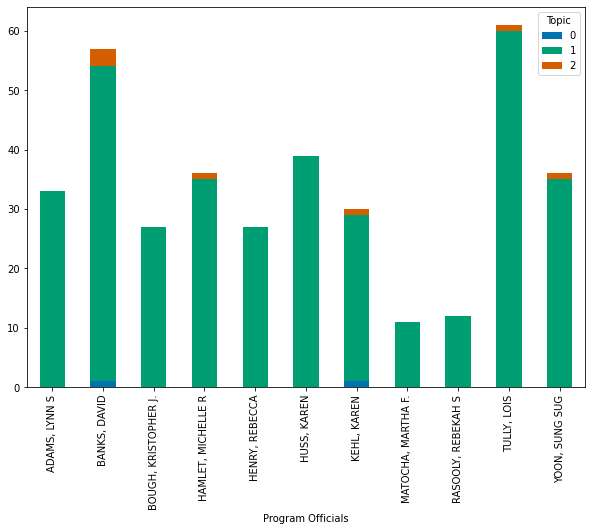

In [296]:
pivot_df = df.pivot(index='Program Officials', columns='Topic', values='#')

for i in range(NUM_TOPICS):
    pivot_df.iloc[:, i] = pandas.to_numeric(pivot_df.iloc[:, i])

pivot_df.plot.bar(stacked=True, figsize=(10,7))

***
###### Topic Visualizations

t-SNE Implementation

In [297]:
# Filter by PO
po_dict = {"ADAMS, LYNN S": 0, "BANKS, DAVID": 1, "BOUGH, KRISTOPHER J.": 2, "HAMLET, MICHELLE R": 3,
           "HENRY, REBECCA" : 4, "HUSS, KAREN" : 5, "KEHL, KAREN" : 6, "MATOCHA, MARTHA F." : 7, 
           "RASOOLY, REBEKAH S" : 8, "TULLY, LOIS" : 9, "YOON, SUNG SUG" : 10}

po_num = []
for index, row in awardedNINR19.iterrows():
    po_num.append(po_dict[row['PO Name']])

print(len(po_num))

369


In [298]:
# filtering by topics
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
arr = pandas.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0] # adjust threshold
topic_num = np.argmax(arr, axis=1)

print(len(topic_num))

369


In [299]:
# build graph
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
output_notebook()
n_topics = NUM_TOPICS
mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 369 samples in 0.002s...
[t-SNE] Computed neighbors for 369 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 369 / 369
[t-SNE] Mean sigma: 0.038941
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.423325
[t-SNE] KL divergence after 1000 iterations: 0.203256


Loading BokehJS ...

In [300]:
# plot graph for topic filters
plot = figure(title="t-SNE Clustering of LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

# plot graph for po filters
plot = figure(title="t-SNE Clustering of Program Officials".format(n_topics), 
              plot_width=900, plot_height=700)


plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[po_num])
show(plot)

pyLDAvis

In [301]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.130419  0.214055       1        1  77.575531
2     -0.163996 -0.198376       2        1  13.397114
0      0.294415 -0.015678       3        1   9.027350, topic_info=              Term         Freq        Total Category  logprob  loglift
82            care  3445.000000  3445.000000  Default  30.0000  30.0000
1006          pain  2221.000000  2221.000000  Default  29.0000  29.0000
216       patients  2455.000000  2455.000000  Default  28.0000  28.0000
215        patient  1504.000000  1504.000000  Default  27.0000  27.0000
268       symptoms  1544.000000  1544.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
823   intervention   310.268707  2740.344971   Topic3  -4.2927   0.2265
212       outcomes   228.856766  1974.455933   Topic3  -4.5971   0.2500
806     healthcare   143.197144   286.930481   Topic3  -5.0660   1.7099
765         burden   153.449738   399.655518   Topic3  -4.9968   1.4477
109           data   179.435654  1475.687866   Topic3  -4.8404   0.2978

[203 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2         1  0.822219          1
2         2  0.136782          1
2         3  0.040882          1
4         1  1.000052         12
9         1  0.911117          2
...     ...       ...        ...
877       2  0.301390  treatment
740       1  0.999561      weeks
484       1  0.999226      women
1070      1  0.998597      years
1072      1  0.999187      youth

[249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

***
###### Word Vectors

In [302]:
awardedNINR19['processed_text'] = texts

In [303]:
awardedNINR19.head()

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text,topic,processed_text
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,"[medical, emergency, team, trigger, clusters, ...",0,"[medical, emergency, team, trigger_clusters, d..."
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,"[neighborhood, disorder, epigenetic, regulatio...",1,"[neighborhood_disorder, epigenetic, regulation..."
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,"[evaluating, contribution, synthetic, oxytocin...",1,"[evaluating, contribution, synthetic_oxytocin,..."
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,"[dementia, informal, caregivers, mobile, app, ...",1,"[dementia, informal, caregivers, mobile_app, i..."
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,"[factors, predicting, transition, readiness, y...",1,"[factors, predicting, transition_readiness, yo..."


In [315]:
topics_list = []
for t in lda_model.show_topics(num_words=10, formatted=False):
    print(t)
    t_list = []
    for w in t[1]:
        t_list.append(w)
    topics_list.append(t_list)
    
print(len(topics_list))

(0, [('care', 0.12536138), ('patients', 0.07158727), ('patient', 0.047396142), ('caregivers', 0.032370735), ('palliative', 0.025577871), ('life', 0.024024023), ('hf', 0.018800247), ('quality', 0.018011596), ('prep', 0.016932305), ('clinical', 0.016101966)])
(1, [('health', 0.01872895), ('intervention', 0.012456195), ('2', 0.011774005), ('1', 0.011030135), ('management', 0.00959982), ('3', 0.009405959), ('outcomes', 0.00854519), ('study', 0.008413092), ('chronic', 0.007875532), ('risk', 0.007174275)])
(2, [('pain', 0.06593698), ('symptoms', 0.0397749), ('symptom', 0.031000543), ('patients', 0.024644805), ('sleep', 0.023351464), ('cancer', 0.016018225), ('function', 0.013492987), ('treatment', 0.013386114), ('data', 0.012664898), ('patient', 0.012592029)])
3


In [313]:
topics = []
for i in range(NUM_TOPICS):
    topics.append([])

for index, row in awardedNINR19.iterrows():
    topic = row['topic']
    topics[topic].append(row['processed_text'])
    
#print(topics) # list of NUM lists, and each of NUM lists consists of multiple processed text lists where NUM is 3 for example

In [316]:
from gensim.models import Word2Vec

models = []
count = 1
for t in topics: #iterates over number of topics
    #y = np.concatenate([np.array(i) for i in t])
    #print(y)
    #print(len(y))
    #print(t) # t is a list of lists, where each nested list contains words from a grant application
    if (count == 1):
        print(t)
    count += 1
    models.append(Word2Vec(t, min_count=1))
    

    
#print(models[0])
#print(models[1])
#print(models[2])

[['medical', 'emergency', 'team', 'trigger_clusters', 'describing', 'symptom', 'experience', 'during', 'clinical', 'deterioration', 'context', 'medical', 'emergency', 'team', 'care', '200', '000', 'patients', 'experience', 'hospital', 'cardiac', 'arrests', 'ihcas', 'annually', 'only', '17', 'survive', 'discharge', 'medical', 'emergency', 'teams', 'mets', 'teams', 'clinicians', 'work', 'improve', 'adverse', 'patient', 'outcomes', 'ihca', 'hospital', 'mortality', 'providing', 'early', 'detection', 'rapid', 'interventions', 'clinically', 'deteriorating', 'patients', 'mets', 'decrease', 'ihca', '38', 'impact', 'patient', 'outcomes', 'remains', 'inconclusive', 'met_triggers', 'signs', 'symptoms', 'clinical', 'deterioration', 'result', 'met', 'activation', 'related', 'symptom', 'experience', 'clinical', 'deterioration', 'provide', 'additional', 'insight', 'multiple', 'met_triggers', 'commonly', 'occur', 'adult', 'pediatric', 'met_events', 'presence', 'multiple', 'met_triggers', 'associated',

In [312]:
for word in models[0].wv.vocab:
    print(word)

medical
emergency
team
trigger_clusters
describing
symptom
experience
during
clinical
deterioration
context
care
200
000
patients
hospital
cardiac
arrests
ihcas
annually
only
17
survive
discharge
teams
mets
clinicians
work
improve
adverse
patient
outcomes
ihca
mortality
providing
early
detection
rapid
interventions
clinically
deteriorating
decrease
38
impact
remains
inconclusive
met_triggers
signs
symptoms
result
met
activation
related
provide
additional
insight
multiple
commonly
occur
adult
pediatric
met_events
presence
associated
high
incidences
however
patterns
explored
concept
met_trigger
clusters
similar
symptom_clusters
groups
distinct
occurring
processes
approach
studying
characteristics
adapting
management
study
examine
conceptualizing
characterizing
relationships
following
proposed
cross_sectional
data
guidelines
resuscitation
registry
module
collects
participating
facilities
separately
samples
34
652
1
075
inpatients
experienced
event
identify
cluster
analysis
2
contextual
fa

Combine and format.

In [307]:
acronym_lookup = {}
acronym_lookup["pa"] = "physical activity"
acronym_lookup["smm"] = "severe maternal morbidity"
acronym_lookup["hf"] = "heart failure"
acronym_lookup["plwh"] = "persons living with HIV"
acronym_lookup["t2dm"] = "type 2 diabetes mellitus"
acronym_lookup["msm"] = "men who have sex with men"
acronym_lookup["fsw"] = "female sex worker"
acronym_lookup["hana"] = "HIV-associated non-AIDS conditions"
acronym_lookup["acp"] = "advance care planning"
acronym_lookup["cds"] = "clinical decision support"
acronym_lookup["cqa"] = "communication quality analysis"
acronym_lookup["cci"] = "chronic critical illness"
acronym_lookup["comt"] = "catechol-O-methyltransferase"
acronym_lookup["bpsd"] = "behavioral and psychological symptoms of dementia"
acronym_lookup["pwd"] = "persons with dementia"
acronym_lookup["fc"] = "fecal calprotectin"
acronym_lookup["eolpc"] = "end of life and palliative care"
acronym_lookup["pcrc"] = "Palliative Care Research Consortium"
acronym_lookup["cmc"] = "children with medical complexity"
acronym_lookup["4_bpsd"] = "behavioral and psychological symptoms of dementia"
acronym_lookup["pes"] = "patient engagement specialist"
acronym_lookup["mcc"] = "multiple chronic conditions"
acronym_lookup["hhc"] = "home healthcare"
acronym_lookup["dts"] = "disinfection tracking system"
acronym_lookup["cri"] = "cardiorespiratory instability"
acronym_lookup["vte"] = "Venous thromboembolism"
acronym_lookup["pru"] = "pruritis"
acronym_lookup["cbpr"] = "community-based participatory research"
acronym_lookup["cbt"] = "cognitive behavioral therapy"
acronym_lookup["trkb"] = "tropomyosin-related receptor kinase type B"
acronym_lookup["lbp"] = "lower back pain"
acronym_lookup["trkb_t1"] = "truncated isoform of Trkb"
acronym_lookup["oa"] = "osteoarthritis"
acronym_lookup["eol"] = "end of life"

In [308]:
combined_list = []
for t in range(len(topics_list)):
    print(t)
    sub_list = []
    for w in topics_list[t]: # w is a tuple
        if (w[0] in acronym_lookup):
            w[0] = acronym_lookup[w[0]]
        print(w)
        similars = models[t].most_similar(positive=[w[0]], topn=10)
        for sim in similars:
            if (sim in acronym_lookup):
                sim = acronym_lookup[sim]
        sub_list.append((w[0], similars))
    combined_list.append(sub_list)

0
('care', 0.12536138)
('patients', 0.07158727)
('patient', 0.047396142)
('caregivers', 0.032370735)


KeyError: "word 'caregivers' not in vocabulary"

In [309]:
pprint(combined_list)

[]
